IMAGE PREPROCESSING

In [1]:
from PIL import Image
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt



In [ ]:
# Path to the dataset
data_path = "E:\\Neural_Project\\Train"

# New size for the images
new_size = (64, 64)

# Function to resize images
def resize_images(folder_path, new_folder_path):
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img = img.resize(new_size)
        new_path = os.path.join(new_folder_path, filename)
        img.save(new_path)

# Resize images
resized_data_path = "E:\\Neural_Project\\resized"
resize_images(data_path, resized_data_path)

print("photoes resized successfully!")

In [ ]:
# Path to the CSV file containing labels
labels_path = "E:\\Neural_Project\\train.csv"

# Directory where the images are stored
images_dir = "E:\\Neural_Project\\resized"

# Directory where the images will be moved and renamed
new_images_dir = "E:\\Neural_Project\\finalTrain"

if not os.path.exists(new_images_dir):
    os.makedirs(new_images_dir)

# Read CSV file
labels_df = pd.read_csv(labels_path)

for i in range(len(labels_df)):
    
    # Getting the current filename from the 'ID' column
    current_filename = labels_df.at[i, 'ID']
    # Creating the new filename
    new_filename = f"{i}.jpg"
    
    # Full path for current and new filenames
    current_filepath = os.path.join(images_dir, current_filename)
    new_filepath = os.path.join(new_images_dir, new_filename)
    
    # Renaming and moving the file
    os.rename(current_filepath, new_filepath)

In [2]:
labels_id = np.empty(200000,dtype=object)
for i in range(len(labels_df)):
    id = i+2
    labels_id[id] = labels_df.at[i,'Class']
    
    
print(labels_id[2])

NameError: name 'labels_df' is not defined

READING THE RESIZED IMAGES

In [3]:
csv_file = "E:\\Neural_Project\\train.csv"
df = pd.read_csv(csv_file)
 
X = []
Y = []
def open_image_as_array(image_path):
    img = Image.open(image_path) 
    img_array = np.array(img)
    img_array = img_array.reshape(64*64*3,)
    return img_array

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    image_path = 'E:\\Neural_Project\\finalTrain\\' + f"{index}.jpg"  # Adjust the path accordingly
    img_array = open_image_as_array(image_path)
    
    # Append the image array along with its class to the X list
    X.append(img_array)
    Y.append(row['Class'])

# Convert X to a NumPy array

X = np.array(X)
Y = np.array(Y)

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)


print(X_train.shape)
print(y_train.shape)

(15924, 12288)
(15924,)


SCALING DATA

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

ONE HOT ENCODING TO THE Y TRAIN

In [5]:
encoder = OneHotEncoder()
y_train = y_train.reshape(-1, 1) 
y_train = encoder.fit_transform(y_train)
y_train = y_train.toarray()
y_train.shape

(15924, 3)

ONE HOT ENCODING TO THE Y TEST

In [6]:
encoder = OneHotEncoder()
y_test = y_test.reshape(-1, 1) 
y_test = encoder.fit_transform(y_test)
y_test = y_test.toarray()
y_test.shape

(3982, 3)

VALIDATION FUNCTIONS AND WEIGHT GENERATION

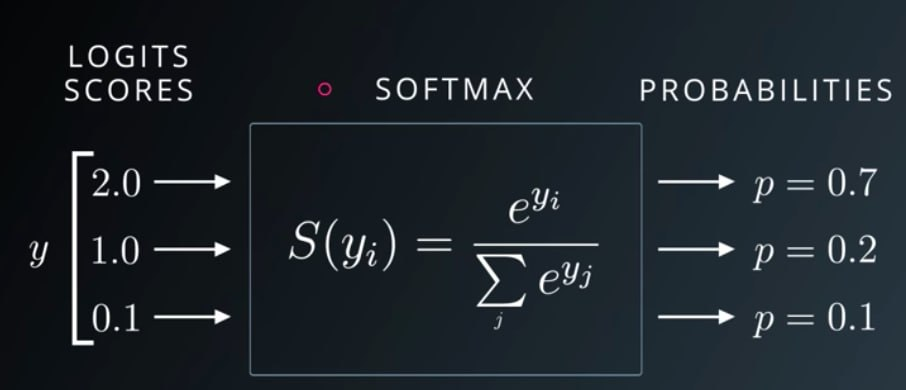

In [7]:
def softmax(z):
    if z.ndim == 1:
        z = z.reshape(1, -1)
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def relu(z):
    return np.maximum(0, z)


def relu_derivative(z):
    return np.where(z > 0, 1, 0)

def softmax_derivative(z):
    softmax_output = softmax(z)
    return softmax_output * (1 - softmax_output)

def generate_wt(x, y):
    l =[]
    for i in range(x * y):
        l.append(np.random.randn()*0.1)
    return(np.array(l).reshape(x, y))

NeuralNetwork CLASS

In [26]:
class NeuralNetwork:


    def __init__(self, x, y, hidden1, hidden2, out):
        self.input      = x
        self.weights1   = generate_wt(self.input.shape[1],hidden1)
        self.weights2   = generate_wt(hidden1,hidden2)
        self.weights3   = generate_wt(hidden2,out)
        self.bias1 = np.zeros(hidden1)
        self.bias2 = np.zeros(hidden2)
        self.bias3 = np.zeros(out)
        self.mu = 0.0001
        self.y          = y
        self.output     = np.zeros(self.y.shape)
        self.loss       = []
        self.init_rprop()
        


    def init_rprop(self):
        init_update_value = 0.006  # Example initial update value
        self.update_values = [np.full_like(self.weights1, init_update_value), 
                              np.full_like(self.weights2, init_update_value),
                              np.full_like(self.weights3, init_update_value),
                              np.full_like(self.bias1, init_update_value),
                              np.full_like(self.bias2, init_update_value),
                              np.full_like(self.bias3, init_update_value)]

        self.prev_grad_sign = [np.zeros_like(self.weights1), 
                               np.zeros_like(self.weights2),
                               np.zeros_like(self.weights3),
                               np.zeros_like(self.bias1),
                               np.zeros_like(self.bias2),
                               np.zeros_like(self.bias3)]
        
    def feedforward(self):
        self.layer1 = relu(np.dot(self.input,self.weights1)+self.bias1)
        self.layer2 = relu(np.dot(self.layer1,self.weights2)+self.bias2)
        self.output = softmax(np.dot(self.layer2,self.weights3)+self.bias3)
        print(f'Cost = {self.cost_function()}')
        print(f'Accuracy = {self.accuracy(self.output,self.y)}')
        print()

    def feedforwardTEST(self):
        self.layer1 = relu(np.dot(self.input,self.weights1)+self.bias1)
        self.layer2 = relu(np.dot(self.layer1,self.weights2)+self.bias2)
        self.output = softmax(np.dot(self.layer2,self.weights3)+self.bias3)

    def test_accuracy(self, test_data, test_labels):
        
        self.input = test_data
        self.feedforwardTEST()

        return self.accuracy(self.output, test_labels)
        
    def cost_function(self):
        m = self.y.shape[0]

        cost = -(1/m)*np.sum(self.y*np.log(self.output))

        return cost
    
    def accuracy(self,output,target):    
        predictions = np.argmax(output, axis=1)
        true_labels = np.argmax(target, axis=1)    
        accuracy = np.mean(predictions == true_labels)
        return accuracy
        
    def backprop(self,l_rate):

        m = len(self.y)
        dz3 = (self.output - self.y)
        dw3 = (1/m)*np.dot(self.layer2.T, dz3)
        db3 = (1/m)*np.sum(dz3, axis = 0, keepdims = True)
        
        dz2 = (1/m)*np.dot(dz3,self.weights3.T)* relu_derivative(self.layer2)
        dw2 = (1/m)*np.dot(self.layer1.T, dz2)
        db2 = (1/m)*np.sum(dz2, axis = 0, keepdims = True)
        
        dz1 = (1/m)*np.dot(dz2,self.weights2.T)* relu_derivative(self.layer1)
        dw1 = (1/m)*np.dot(self.input.T, dz1)
        db1 = (1/m)*np.sum(dz1, axis = 0, keepdims = True)
    
    
        self.weights1 = self.weights1 - (l_rate * dw1)        
        self.weights2 = self.weights2 - (l_rate * dw2)
        self.weights3 = self.weights3 - (l_rate * dw3)  

        self.bias1 = self.bias1 - (l_rate * db1)
        self.bias2 = self.bias2 - (l_rate * db2)        
        self.bias3 = self.bias3 - (l_rate * db3)
        
        nn.loss.append(self.cost_function())


    def Resilient_Propagation(self):

        m = len(self.y)
        dz3 = (self.output - self.y)
        dw3 = (1/m)*np.dot(self.layer2.T, dz3)
        db3 = (1/m)*np.sum(dz3, axis = 0, keepdims = True)
        
        dz2 = (1/m)*np.dot(dz3,self.weights3.T)* relu_derivative(self.layer2)
        dw2 = (1/m)*np.dot(self.layer1.T, dz2)
        db2 = (1/m)*np.sum(dz2, axis = 0, keepdims = True)
        
        dz1 = (1/m)*np.dot(dz2,self.weights2.T)* relu_derivative(self.layer1)
        dw1 = (1/m)*np.dot(self.input.T, dz1)
        db1 = (1/m)*np.sum(dz1, axis = 0, keepdims = True)
        
        self.loss.append(self.cost_function())

        return dw1, db1, dw2, db2, dw3, db3 
    
    
    def lm_backprop(self):
        m = len(self.y)
        dz3 = (self.output - self.y)
        dw3 = (1/m)*np.dot(self.layer2.T, dz3)
        db3 = (1/m)*np.sum(dz3, axis = 0, keepdims = True)

        dz2 = (1/m)*np.dot(dz3,self.weights3.T)* relu_derivative(self.layer2)
        dw2 = (1/m)*np.dot(self.layer1.T, dz2)
        db2 = (1/m)*np.sum(dz2, axis = 0, keepdims = True)

        dz1 = (1/m)*np.dot(dz2,self.weights2.T)* relu_derivative(self.layer1)
        dw1 = (1/m)*np.dot(self.input.T, dz1)
        db1 = (1/m)*np.sum(dz1, axis = 0, keepdims = True)

        prev_weights3 = self.weights3
        J_w3 = (1/m)*np.dot(self.layer2.T, dz3)
        H_w3 = np.dot(J_w3, J_w3.T)
        H_w3 = H_w3 + self.mu * np.identity(H_w3.shape[1])
        H_inv = np.linalg.solve(H_w3, np.eye(H_w3.shape[0]))
        self.weights3 = self.weights3 - H_inv @ J_w3

        prev_weights2 = self.weights2
        J_w2 = np.dot(self.layer1.T, dz2)
        H_w2 = np.dot(J_w2, J_w2.T)
        H_w2 = H_w2 + self.mu * np.identity(H_w2.shape[1])
        H_inv = np.linalg.solve(H_w2, np.eye(H_w2.shape[0]))
        self.weights2 = self.weights2 - H_inv @ J_w2

        prev_weights1 = self.weights1
        J_w1 = np.dot(self.input.T, dz1)
        H_w1 = np.dot(J_w1, J_w1.T)
        H_w1 = H_w1 + self.mu * np.identity(H_w1.shape[1])
        H_inv = np.linalg.solve(H_w1, np.eye(H_w1.shape[0]))
        self.weights1 = self.weights1 - H_inv @ J_w1

        prev_b3 = self.bias3
        J_b3 = (1/m)*np.sum(dz3, axis = 0, keepdims = True)
        H_b3 = np.dot(J_b3, J_b3.T)
        H_b3 = H_b3 + self.mu * np.identity(H_b3.shape[1])
        H_inv = np.linalg.solve(H_b3, np.eye(H_b3.shape[0]))
        self.bias3 = self.bias3 - H_inv @ J_b3

        prev_b2 = self.bias2
        J_b2 = (1/m)*np.sum(dz2, axis = 0, keepdims = True)
        H_b2 = np.dot(J_b2, J_b2.T)
        H_b2 = H_b2 + self.mu * np.identity(H_b2.shape[1])
        H_inv = np.linalg.solve(H_b2, np.eye(H_b2.shape[0]))
        self.bias2 = self.bias2 - H_inv @ J_b2

        prev_b1 = self.bias1
        J_b1 = (1/m)*np.sum(dz1, axis = 0, keepdims = True)
        H_b1 = np.dot(J_b1, J_b1.T)
        H_b1 = H_b1 + self.mu * np.identity(H_b1.shape[1])
        H_inv = np.linalg.solve(H_b1, np.eye(H_b1.shape[0]))
        self.bias1 = self.bias1 - H_inv @ J_b1


        if (len(self.loss) == 0):
            old_cost = 1000000
        else :
            old_cost = self.loss[-1]

        self.feedforward()
        new_cost = self.cost_function()

        if (new_cost > old_cost):
            self.mu *= 10
            self.weights1 = prev_weights1
            self.weights2 = prev_weights2
            self.weights3 = prev_weights3
            self.bias1 = prev_b1
            self.bias2 = prev_b2
            self.bias3 = prev_b3
            self.feedforward()
            self.loss.append(old_cost)

        else:
            self.loss.append(self.cost_function())
            self.mu /= 10
            
        
    


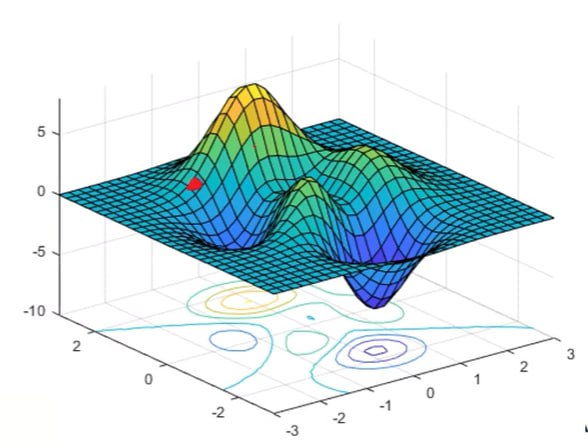

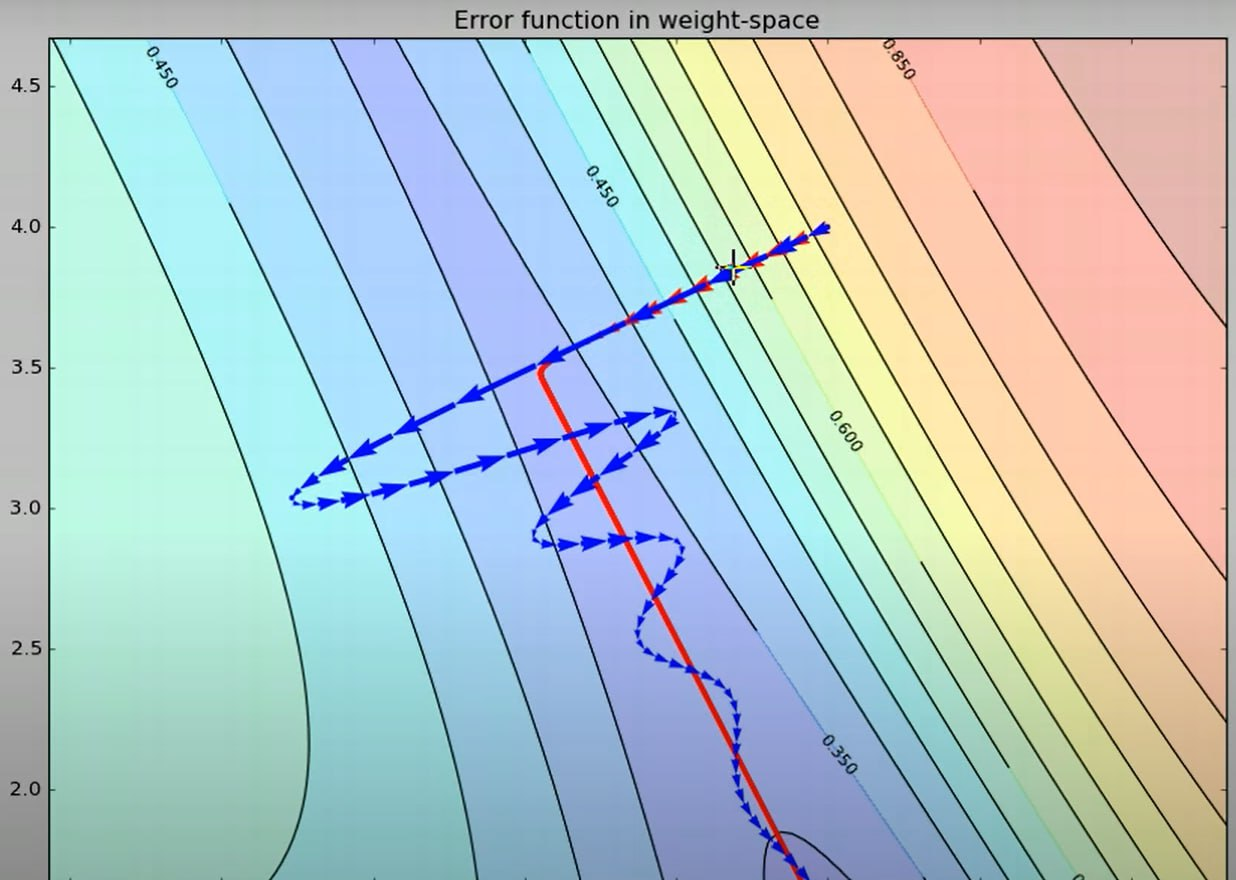

In [11]:
def rprop_update(nn, gradients):
    # Unpack gradients
    dw1, db1, dw2, db2, dw3, db3 = gradients


    for i, (param, grad, prev_grad_sign, update_value) in enumerate(zip(
            [nn.weights1, nn.weights2, nn.weights3, nn.bias1, nn.bias2, nn.bias3],
            [dw1, dw2, dw3, db1, db2, db3],
            nn.prev_grad_sign,
            nn.update_values)):

        new_grad_sign = np.sign(grad)
        sign_change = new_grad_sign * prev_grad_sign
        increase = (sign_change > 0)
        decrease = (sign_change < 0)

        # Handle different dimensions for weights and biases
        if param.ndim > 1:  
            update_value[increase] *= 1.2
            update_value[decrease] *= 0.5
        else:  # For biases
            increase_flat = increase.flatten()
            decrease_flat = decrease.flatten()
            update_value[increase_flat] *= 1.2
            update_value[decrease_flat] *= 0.5

        param_update = np.sign(grad) * update_value
        param_update[decrease] = 0

        if param.ndim == 1:
            param_update = param_update.flatten()

        param -= param_update
        np.copyto(prev_grad_sign, new_grad_sign)


TRAINING THE MODEL

In [12]:
nn = NeuralNetwork(X_train,y_train,120,120,3)
epoches = 1000
learning_rate = 0.006
nn.loss=[]
iterations =[]

for i in range(epoches):
    print(f"Epoch {i+1} :")
    nn.feedforward()
    nn.backprop(learning_rate)
    iterations.append(i)
    


Epoch 1 :
Cost = 2.6399085888049783
Accuracy = 0.25395629238884704

Epoch 2 :
Cost = 1.8557910495102963
Accuracy = 0.483232856066315

Epoch 3 :
Cost = 1.4323605099724994
Accuracy = 0.4697940216026124

Epoch 4 :
Cost = 1.1870076902300708
Accuracy = 0.46527254458678724

Epoch 5 :
Cost = 1.1232627012538097
Accuracy = 0.46163024365737254

Epoch 6 :
Cost = 1.1120290416981506
Accuracy = 0.4647073599598091

Epoch 7 :
Cost = 1.1075280020947071
Accuracy = 0.46721929163526754

Epoch 8 :
Cost = 1.1045705860338428
Accuracy = 0.46860085405676966

Epoch 9 :
Cost = 1.1020960298139915
Accuracy = 0.4701708113539312

Epoch 10 :
Cost = 1.0998028587572029
Accuracy = 0.47148957548354686

Epoch 11 :
Cost = 1.097594802918519
Accuracy = 0.4724943481537302

Epoch 12 :
Cost = 1.0954388705362703
Accuracy = 0.47324792765636775

Epoch 13 :
Cost = 1.0933230638152382
Accuracy = 0.4739387088671188

Epoch 14 :
Cost = 1.0912426563477278
Accuracy = 0.474378296910324

Epoch 15 :
Cost = 1.0891955100333426
Accuracy = 0.474

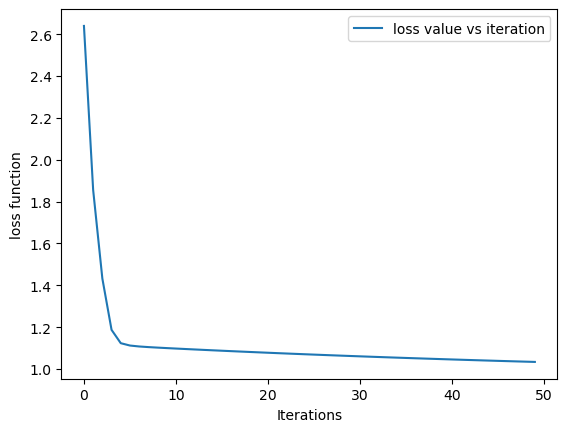

In [13]:
plt.plot(iterations, nn.loss, label='loss value vs iteration')
plt.xlabel('Iterations')
plt.ylabel('loss function')
plt.legend()
plt.show()

PRINTING PREDICT VS TRUE LABELS

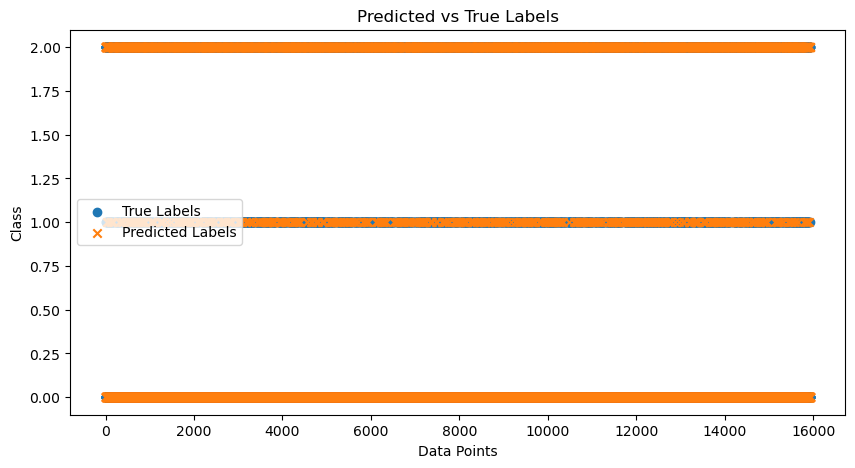

In [14]:
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(X_train)), np.argmax(y_train, axis=1), label='True Labels', marker='o')
plt.scatter(np.arange(len(X_train)), np.argmax(nn.output, axis=1), label='Predicted Labels', marker='x')
plt.xlabel('Data Points')
plt.ylabel('Class')
plt.title('Predicted vs True Labels')
plt.legend()
plt.show()

TEST ACCURACY

In [15]:
nn.input = X_test

test_accuracy = nn.test_accuracy(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100}%")

Test Accuracy: 50.60271220492215%


Resilient Propagation

In [16]:
nn2 = NeuralNetwork(X_train,y_train,120,120,3)
epoches = 800
learning_rate = 0.006
nn2.loss=[]
iterations =[]

for i in range(epoches):
    print(f"Epoch {i+1} :")
    nn2.feedforward()
    grads = nn2.Resilient_Propagation()
    rprop_update(nn2, grads)
    iterations.append(i)
    


Epoch 1 :
Cost = 1.5119054752736116
Accuracy = 0.3475885455915599

Epoch 2 :
Cost = 58.016080619102205
Accuracy = 0.5415096709369505

Epoch 3 :
Cost = 47.201230284154754
Accuracy = 0.5415096709369505

Epoch 4 :
Cost = 86.28169569780894
Accuracy = 0.12088671188143682

Epoch 5 :
Cost = 30.406675171746
Accuracy = 0.12088671188143682

Epoch 6 :
Cost = 18.503272276437507
Accuracy = 0.5415096709369505

Epoch 7 :
Cost = 12.955612942134366
Accuracy = 0.3379804069329314

Epoch 8 :
Cost = 8.208672563854487
Accuracy = 0.41829942225571465

Epoch 9 :
Cost = 16.122792595564903
Accuracy = 0.5415096709369505

Epoch 10 :
Cost = 10.982207187186967
Accuracy = 0.5415096709369505

Epoch 11 :
Cost = 7.672517203769539
Accuracy = 0.12088671188143682

Epoch 12 :
Cost = 6.499987859931
Accuracy = 0.33760361718161264

Epoch 13 :
Cost = 2.137239536300368
Accuracy = 0.3781085154483798

Epoch 14 :
Cost = 7.477492977471464
Accuracy = 0.5415096709369505

Epoch 15 :
Cost = 6.440995319733454
Accuracy = 0.541509670936950

ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

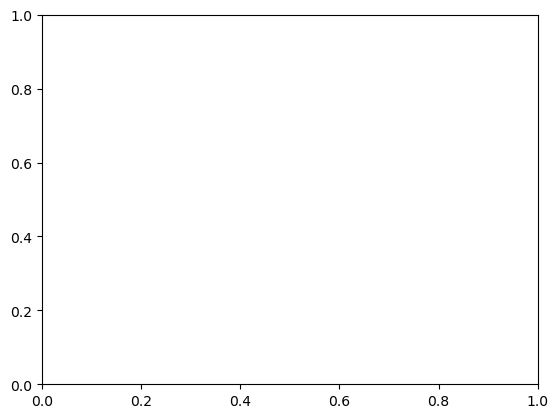

In [18]:
plt.plot(iterations, nn2.loss, label='loss value vs iteration')
plt.xlabel('Iterations')
plt.ylabel('loss function')
plt.legend()
plt.show()

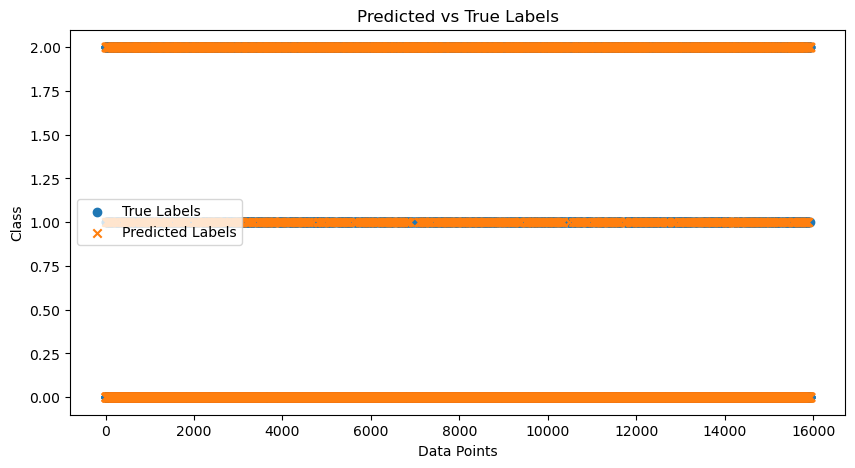

In [19]:
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(X_train)), np.argmax(y_train, axis=1), label='True Labels', marker='o')
plt.scatter(np.arange(len(X_train)), np.argmax(nn2.output, axis=1), label='Predicted Labels', marker='x')
plt.xlabel('Data Points')
plt.ylabel('Class')
plt.title('Predicted vs True Labels')
plt.legend()
plt.show()

In [20]:
nn2.input = X_test


test_accuracy = nn2.test_accuracy(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100}%")

Test Accuracy: 54.570567553992966%


Levenberg-Marquardt

In [21]:
import matplotlib.pyplot as plt
nn3 = NeuralNetwork(X_train,y_train,3,3,3)
epoches = 50
learning_rate = 0.006
nn3.loss=[]
iterations =[]
for i in range(epoches):
    print(f"Epoch {i+1} :")
    nn3.feedforward()
    print(f'Cost = {nn3.cost_function()}')
    print(f'Accuracy = {nn3.accuracy(nn.output,nn.y)}')
    print()
    #nn.backprop(learning_rate)
    nn3.lm_backprop()
    iterations.append(i)
    
plt.plot(iterations, nn3.loss, label='loss value vs iteration')
plt.xlabel('Iterations')
plt.ylabel('loss function')
plt.legend()
plt.show()

Epoch 1 :
Cost = 1.1118739638365405
Accuracy = 0.13237879929665913

Cost = 1.1118739638365405
Accuracy = 0.0



C:\Users\obada\AppData\Local\Temp\ipykernel_12840\420197095.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.mean(predictions == true_labels)


Cost = 31.467505415746725
Accuracy = 0.3383571966842502

Epoch 2 :
Cost = 31.467505415746725
Accuracy = 0.3383571966842502

Cost = 31.467505415746725
Accuracy = 0.0

Cost = 21.448835809469863
Accuracy = 0.5415096709369505

Epoch 3 :
Cost = 21.448835809469863
Accuracy = 0.5415096709369505

Cost = 21.448835809469863
Accuracy = 0.0



KeyboardInterrupt: 

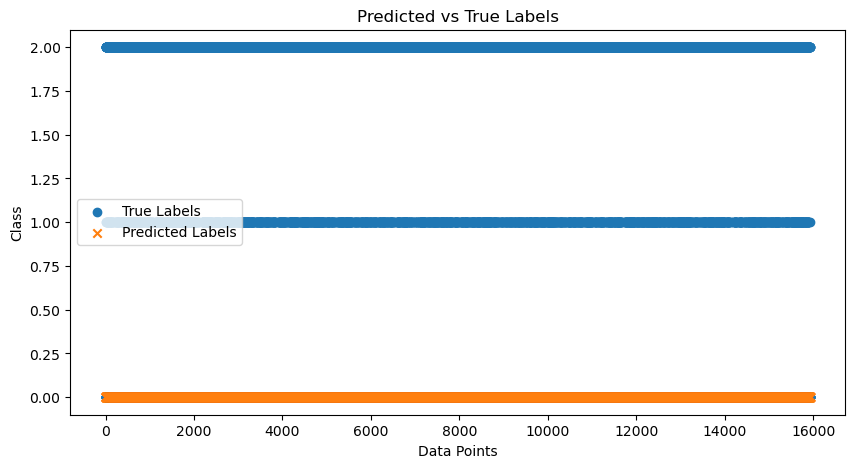

In [22]:
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(X_train)), np.argmax(y_train, axis=1), label='True Labels', marker='o')
plt.scatter(np.arange(len(X_train)), np.argmax(nn3.output, axis=1), label='Predicted Labels', marker='x')
plt.xlabel('Data Points')
plt.ylabel('Class')
plt.title('Predicted vs True Labels')
plt.legend()
plt.show()

Building Network Using Keras

In [23]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
model3 = Sequential()

model3.add(Dense(256, input_dim=12288, activation='relu',  kernel_regularizer=regularizers.l2(0.01)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(3, activation='softmax'))

model3.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.0065),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model3.fit(
    X_train, y_train,
    epochs=200,
    batch_size=128,
    verbose=True,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
100/100 [==============================] - 13s 79ms/step - loss: 9.5462 - accuracy: 0.3864 - val_loss: 8.8172 - val_accuracy: 0.5391
Epoch 2/50
100/100 [==============================] - 6s 60ms/step - loss: 9.0747 - accuracy: 0.4324 - val_loss: 8.5898 - val_accuracy: 0.5868
Epoch 3/50
 91/100 [==========================>...] - ETA: 0s - loss: 8.7210 - accuracy: 0.4767

KeyboardInterrupt: 

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [28]:
score_3 = model3.evaluate(X_test, y_test, verbose=1)
print("Test score:", score_3[0])
print('Test accuracy:', score_3[1])

125/125 [==============================] - 2s 13ms/step - loss: 8.3658 - accuracy: 0.6145
Test score: 8.365774154663086
Test accuracy: 0.6145153045654297
